<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/dev2/modelo58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip

--2024-04-19 16:09:00--  https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fuld3z222j9t1oy/vs_release_16k.zip [following]
--2024-04-19 16:09:00--  https://www.dropbox.com/s/raw/fuld3z222j9t1oy/vs_release_16k.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3c03d8d300435724dbcf929608.dl.dropboxusercontent.com/cd/0/inline/CRXFSCQdhbBAz4d6ZeulVz1PTVpevarggwfY_dP5lT7uwgwH9T9dV5QaKinYnWTimObC-zty5udNf_eai8GgfGZqVZue0kBS98ehHA08h0aTWolqpPDVZPMlFfraXImTQHvPI4WnKuSYf_1Yu8MhSxHB/file# [following]
--2024-04-19 16:09:01--  https://uc3c03d8d300435724dbcf929608.dl.dropboxusercontent.com/cd/0/inline/CRXFSCQdhbBAz4d6ZeulVz1PTVpevarggwfY_dP5lT7uwgwH9T9dV5QaKinYnWTimObC-zty5udNf_eai8Gg

In [2]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [3]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [4]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

filenames = tf.io.gfile.glob(audio_dir + '*')
filenames = tf.random.shuffle(filenames, seed)

print('Total audios:', len(filenames))
print('Example:', filenames.shape)

Total audios: 21023
Example: (21023,)


In [5]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)

test_file = filenames[0]
def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  label = tf.where(label==vocal_sounds)
  label = tf.reshape(label, ())
  return label

get_label(test_file), test_file

(<tf.Tensor: shape=(), dtype=int64, numpy=4>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m1059_0_sniff.wav'>)

In [6]:
std_len = 64000
def get_signal(file_path):
  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]
  signal = signal[:std_len]
  signal = tf.pad(signal, [[0, std_len-len(signal)], [0, 0]])
  return tf.squeeze(signal, axis=-1)

get_signal(test_file), test_file

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
 array([-0.00796509, -0.0135498 , -0.01300049, ...,  0.        ,
         0.        ,  0.        ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m1059_0_sniff.wav'>)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
ds_files.element_spec, ds_signals.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

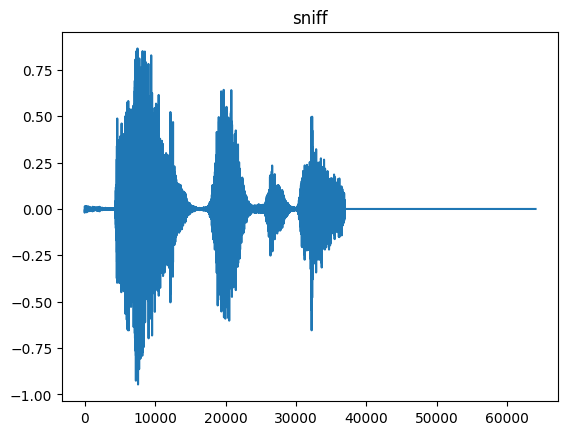

In [8]:
import matplotlib.pyplot as plt
for elem in ds_signals.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(vocal_sounds[label])

In [9]:
def remove_shortaudio(filename):
  if get_signal(filename).shape[0] < min_len:
    tf.io.gfile.remove(filename)

initial_file_count = 21024

if len(filenames) >= initial_file_count:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  with ThreadPoolExecutor() as exe:
    for file in filenames:
      exe.submit(remove_shortaudio, file)

  filenames = tf.io.gfile.glob(audio_dir + '*')

print('Total audios:', len(filenames))


Total audios: 21023


In [10]:
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

In [11]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([-0.00796509, -0.0135498 , -0.01300049, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)


In [12]:
def normalize(audio, label):
  label = tf.one_hot(label, len(vocal_sounds))
  return audio, label

ds_signals = ds_signals.map(normalize).cache()

In [13]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([-0.00796509, -0.0135498 , -0.01300049, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0.], dtype=float32)>)


In [14]:
ds_signals.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(6,), dtype=tf.float32, name=None))

In [15]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [16]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [19]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(64000, 1)),
    MaxPooling1D(2),
    Conv1D(16, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(6, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 63998, 32)         128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 31999, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 31997, 16)         1552      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 15998, 16)         0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 255968)            0         
                                                                 
 dense (Dense)               (None, 32)                8

In [21]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Epoch 1/100
138/138 [==============================] - 91s 280ms/step - loss: 0.3961 - accuracy: 0.4238 - val_loss: 0.3650 - val_accuracy: 0.4719 - lr: 0.0010
Epoch 2/100
138/138 [==============================] - 38s 276ms/step - loss: 0.3220 - accuracy: 0.5700 - val_loss: 0.3499 - val_accuracy: 0.5180 - lr: 0.0010
Epoch 3/100
138/138 [==============================] - 36s 259ms/step - loss: 0.2596 - accuracy: 0.6879 - val_loss: 0.3718 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 4/100
138/138 [==============================] - 36s 262ms/step - loss: 0.1885 - accuracy: 0.8002 - val_loss: 0.4246 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 5/100
138/138 [==============================] - 36s 260ms/step - loss: 0.1278 - accuracy: 0.8779 - val_loss: 0.5098 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 6/100
138/138 [==============================] - 36s 259ms/step - loss: 0.0915 - accuracy: 0.9209 - val_loss: 0.6402 - val_accuracy: 0.5007 - lr: 0.0010
Epoch 7/100
138/138 [=========================

In [22]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 [==============================] - 4s 128ms/step - loss: 0.5566 - accuracy: 0.5885
Test accuracy: 0.5884871482849121
